### Deep Efficient (Partial) Hedging


Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T.
$$
Given $V_0$, find the best 0-admissible adapted self-financing strategy $H$ that minimize
$$
\mathbb{E}[\ell ((Z-V_T)_+)]
$$
where $Z$ is the payoff and $\ell(x) = \frac{x^{p}}{p},\quad p > 0$.

We numerically minimize the loss consisting of three terms
\begin{equation}
    \mathcal{L}(K) = \mathcal{L}_{p}(K) + \mathcal{L}_{\text{ad}}(K),
\end{equation}
where 
\begin{equation*}
\begin{aligned}
    \mathcal{L}_{p}(K) &= \mathbb{E}\Big[\ell ((Z-V_T)_+) \Big],\\
    \mathcal{L}_{\text{ad}}(K) &= c_{\text{ad}}\mathbb{E}\Big[(-\min_{t}V_{t})_{+}\Big],
\end{aligned}
\end{equation*}

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../src')

## BS market

In [2]:
import torch
from neuralhedge.nn import datahedger
from neuralhedge.utils.plotting import plot_hedge_ds
from neuralhedge.data.market import BS_Market
from neuralhedge.utils.evaluation import evaluate_bs_deep_hedge

Shape of paths:  torch.Size([10000, 31, 2])
Shape of information:  torch.Size([10000, 31, 2])
Shape of payoff:  torch.Size([10000])


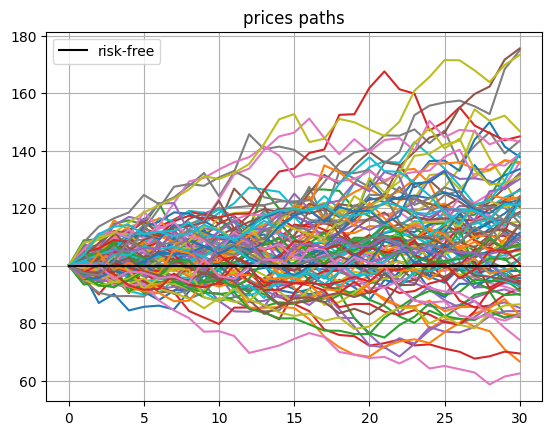

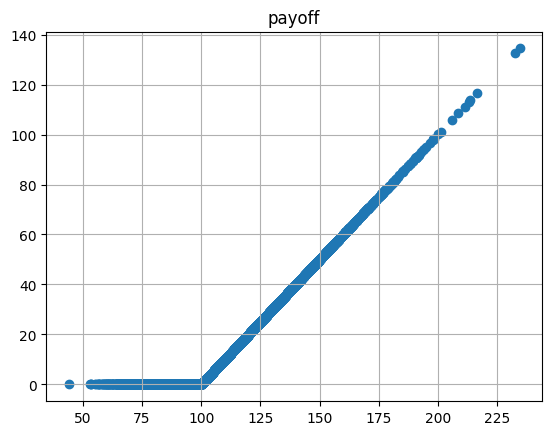

In [3]:
bs_market = BS_Market()
ds_train = bs_market.get_hedge_ds()
ds_test = bs_market.get_hedge_ds()
plot_hedge_ds(ds_train)

## Delta Hedge

In [4]:
from neuralhedge.utils.evaluation import evaluate_bs_efficient_hedge
init_wealth = torch.tensor(5.0)
bs_price, bs_delta = bs_market.get_price_delta()
delta_hedger = datahedger.EfficientHedger(bs_delta, init_wealth=torch.zeros(1))
record_dir = './efficienthedge/bs_call_delta'
evaluate_bs_efficient_hedge(delta_hedger, ds_test, bs_price, init_wealth, record_dir)

Save evaluation at: ./efficienthedge/bs_call_delta
BS price: 7.97
initial wealth: 5.00
Risk(p=1): 3.07
Risk(p=2): 1.71
Risk(p=0.5): 5.50
Entropic Measure: 4.01
Square Measure: 4.26
Expected Shortfall (q=0.5): 4.24
Expected Shortfall (q=0.9): 3.39


## Efficient Hedge

In [5]:
from neuralhedge.nn import datahedger, network
from neuralhedge.utils.plotting import plot_history
from neuralhedge.nn.trainer import Trainer
from neuralhedge.nn import loss

In [6]:
initial_wealth = torch.tensor(5.0)
admissible_bound = -5
p = 1

n_asset = ds_train.prices.shape[-1]
strategy = network.NeuralNetSequential(n_output = n_asset-1)
hedger = datahedger.EfficientHedger(strategy,
                                    init_wealth=initial_wealth,
                                    risk = loss.PowerMeasure(p),
                                    ad_bound=admissible_bound) 
trainer = Trainer(hedger)
trainer.fit(ds_train, EPOCHS=100, lr_scheduler_gamma=0.99, lr = 0.005) 

/Users/hous/Github/NeuralHedge/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=3.3508188724517822:  87%|████████▋ | 87/100 [00:45<00:06,  2.11it/s]

In [ ]:
from neuralhedge.utils.evaluation import evaluate_bs_efficient_hedge
record_dir = './efficienthedge/bs_call_p=1/'
plot_history(trainer.history,record_dir)
evaluate_bs_efficient_hedge(hedger, ds_test, bs_price, init_wealth, record_dir)


Save evaluation at: ./efficienthedge/bs_call_p=1/
BS price: 7.97
initial wealth: 5.00
Risk(p=1): 2.15
Risk(p=2): 2.13
Risk(p=0.5): 1.52
Entropic Measure: 10.33
Square Measure: 21.69
Expected Shortfall (q=0.5): 4.30
Expected Shortfall (q=0.9): 1.62
